# Scan Simulator
Apply realistic "printed and scanned" effects to documents.

**Effects:**
- Slight rotation/skew (paper misalignment)
- Off-white paper tone
- Noise/grain (scanner sensor noise)
- Adjusted contrast/brightness
- Optional blur and edge shadows

In [1]:
import os
import random
from pathlib import Path
from IPython.display import display, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

try:
    from PIL import Image, ImageFilter, ImageEnhance, ImageDraw
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'Pillow'])
    from PIL import Image, ImageFilter, ImageEnhance, ImageDraw

try:
    import numpy as np
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'numpy'])
    import numpy as np

print("All dependencies loaded!")

All dependencies loaded!


In [2]:
# Configuration
FILLED_DOCUMENTS_FOLDER = Path("filled_documents")
OUTPUT_FOLDER = Path("filled_documents")  # Save scanned versions to same folder

# Scan effect presets - INCREASED ROTATION AND BLUR
# blur_range starts at 0 to allow some clear/sharp versions
SCAN_PRESETS = {
    "light": {
        "rotation_range": 1.5,
        "noise_amount": 3,
        "paper_tone": (253, 251, 248),
        "brightness_range": (0.97, 1.0),
        "contrast_range": (0.96, 1.0),
        "blur_range": (0, 1.0)      # 0 = some will be clear
    },
    "medium": {
        "rotation_range": 3.0,
        "noise_amount": 8,
        "paper_tone": (250, 247, 240),
        "brightness_range": (0.94, 0.99),
        "contrast_range": (0.90, 0.96),
        "blur_range": (0, 1.5)      # 0 = some will be clear
    },
    "heavy": {
        "rotation_range": 5.0,
        "noise_amount": 15,
        "paper_tone": (245, 240, 230),
        "brightness_range": (0.90, 0.96),
        "contrast_range": (0.82, 0.90),
        "blur_range": (0, 2.0)      # 0 = some will be clear
    }
}

In [3]:
def apply_paper_tone(img, tone=(252, 250, 245)):
    """Apply off-white paper tone to white areas."""
    img_array = np.array(img).astype(np.float32)
    
    # Create a mask for white/light areas (where we want to apply the tone)
    # The lighter the pixel, the more tone we apply
    luminance = (0.299 * img_array[:,:,0] + 0.587 * img_array[:,:,1] + 0.114 * img_array[:,:,2]) / 255.0
    
    # Blend towards paper tone based on how light the pixel is
    for i, t in enumerate(tone):
        blend_factor = luminance ** 2  # More effect on lighter areas
        img_array[:,:,i] = img_array[:,:,i] * (1 - blend_factor * 0.3) + t * blend_factor * 0.3
    
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    return Image.fromarray(img_array)

def apply_noise(img, amount=5):
    """Add random noise to simulate scanner grain."""
    img_array = np.array(img).astype(np.float32)
    noise = np.random.normal(0, amount, img_array.shape)
    img_array = img_array + noise
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    return Image.fromarray(img_array)

def apply_scan_effects(img, preset="medium", seed=None):
    """
    Apply realistic scan effects to an image.
    
    Parameters:
    - img: PIL Image
    - preset: "light", "medium", or "heavy"
    - seed: Random seed for reproducibility (None for random)
    
    Returns: PIL Image with scan effects applied
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    settings = SCAN_PRESETS.get(preset, SCAN_PRESETS["medium"])
    
    # 1. Apply paper tone (off-white background)
    img = apply_paper_tone(img, settings["paper_tone"])
    
    # 2. Apply rotation (random within range)
    rotation = random.uniform(-settings["rotation_range"], settings["rotation_range"])
    # Expand canvas to avoid cutting corners, fill with paper tone
    img = img.rotate(rotation, expand=True, fillcolor=settings["paper_tone"], resample=Image.BICUBIC)
    
    # 3. Apply brightness adjustment
    brightness = random.uniform(*settings["brightness_range"])
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    
    # 4. Apply contrast adjustment
    contrast = random.uniform(*settings["contrast_range"])
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    
    # 5. Apply slight blur
    blur = random.uniform(*settings["blur_range"])
    img = img.filter(ImageFilter.GaussianBlur(radius=blur))
    
    # 6. Apply noise
    img = apply_noise(img, settings["noise_amount"])
    
    print(f"Applied '{preset}' preset: rotation={rotation:.2f}°, brightness={brightness:.2f}, contrast={contrast:.2f}, blur={blur:.2f}")
    
    return img

def save_as_pdf(img, output_path):
    """Save PIL image as PDF."""
    # Convert to RGB if necessary (PDF doesn't support RGBA)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img.save(output_path, 'PDF', resolution=150)
    print(f"Saved PDF: {output_path}")

In [4]:
# List available filled documents
filled_docs = sorted([f for f in FILLED_DOCUMENTS_FOLDER.iterdir() 
                      if f.suffix.lower() == '.png' and '_scanned' not in f.name])

if not filled_docs:
    print(f"No PNG files found in '{FILLED_DOCUMENTS_FOLDER}' folder.")
    print("Run form_filler.ipynb first to generate filled documents.")
else:
    print("Available documents to scan:")
    for i, doc in enumerate(filled_docs):
        print(f"  {i}: {doc.name}")

Available documents to scan:
  0: Demand Letter_filled_computer.png
  1: Demand Letter_filled_handwriting.png


In [5]:
# ============================================================
# CONFIGURATION: Select document and scan preset
# ============================================================
SELECTED_DOC_INDEX = 0      # Which document to scan (from list above)
SCAN_PRESET = "medium"      # "light", "medium", or "heavy"

if filled_docs:
    selected_doc = filled_docs[SELECTED_DOC_INDEX]
    print(f"Selected: {selected_doc.name}")
    print(f"Preset: {SCAN_PRESET}")
    
    # Load the image
    original_img = Image.open(selected_doc)
    print(f"Image size: {original_img.size}")
else:
    print("No documents available")

Selected: Demand Letter_filled_computer.png
Preset: medium
Image size: (1224, 1584)


Generating 5 scanned versions of Demand Letter_filled_computer.png...

Applied 'medium' preset: rotation=0.82°, brightness=0.98, contrast=0.94, blur=0.96
Saved: filled_documents\Demand Letter_filled_computer_1.png

Applied 'medium' preset: rotation=2.18°, brightness=0.98, contrast=0.92, blur=1.08
Saved: filled_documents\Demand Letter_filled_computer_2.png

Applied 'medium' preset: rotation=1.47°, brightness=0.95, contrast=0.90, blur=0.66
Saved: filled_documents\Demand Letter_filled_computer_3.png

Applied 'medium' preset: rotation=-2.95°, brightness=0.95, contrast=0.90, blur=1.16
Saved: filled_documents\Demand Letter_filled_computer_4.png

Applied 'medium' preset: rotation=-0.85°, brightness=0.98, contrast=0.91, blur=1.39
Saved: filled_documents\Demand Letter_filled_computer_5.png

Done! Created 5 versions.

Last version preview:


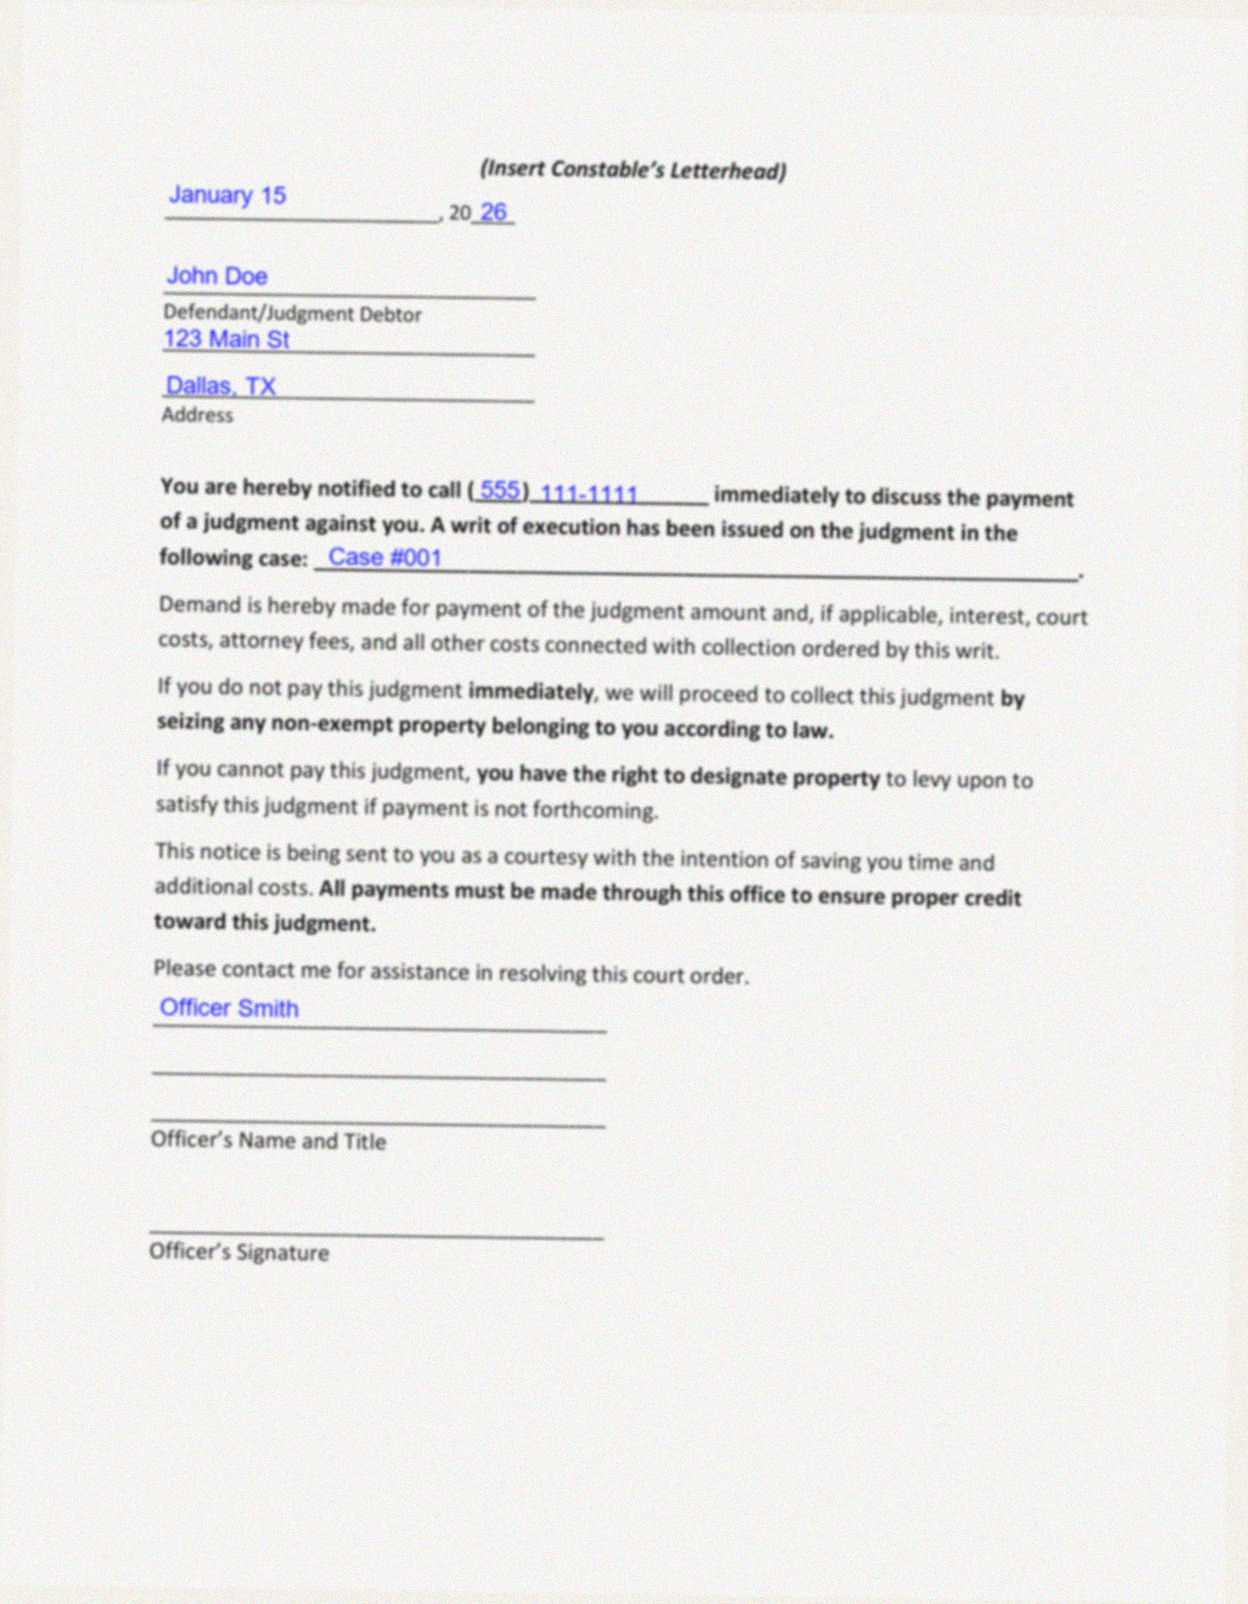

In [6]:
# Apply scan effects and save 5 versions of selected document
NUM_VERSIONS = 5

if 'original_img' in dir():
    print(f"Generating {NUM_VERSIONS} scanned versions of {selected_doc.name}...\n")
    
    for version in range(1, NUM_VERSIONS + 1):
        # Reload original to avoid compounding effects
        img = Image.open(selected_doc)
        
        # Apply effects (different random values each time)
        scanned_img = apply_scan_effects(img, preset=SCAN_PRESET)
        
        # Generate output filename with version number (PNG only)
        base_name = selected_doc.stem
        png_path = OUTPUT_FOLDER / f"{base_name}_{version}.png"
        
        # Save PNG
        scanned_img.save(png_path)
        print(f"Saved: {png_path}\n")
    
    print(f"Done! Created {NUM_VERSIONS} versions.")
    
    # Display the last version
    print("\nLast version preview:")
    display(IPImage(filename=str(png_path), width=600))
else:
    print("Load a document first (run the cell above)")

In [7]:
# Batch process: Create 5 versions of ALL filled documents
NUM_VERSIONS = 5

if filled_docs:
    total_files = len(filled_docs) * NUM_VERSIONS
    print(f"Processing {len(filled_docs)} documents × {NUM_VERSIONS} versions = {total_files} total files")
    print(f"Using '{SCAN_PRESET}' preset...\n")
    
    for doc in filled_docs:
        print(f"Processing: {doc.name}")
        
        for version in range(1, NUM_VERSIONS + 1):
            # Load fresh copy each time
            img = Image.open(doc)
            scanned = apply_scan_effects(img, preset=SCAN_PRESET)
            
            # Save with version number postfix (PNG only)
            base_name = doc.stem
            png_path = OUTPUT_FOLDER / f"{base_name}_{version}.png"
            
            scanned.save(png_path)
        
        print(f"  Created {NUM_VERSIONS} versions\n")
    
    print(f"Done! Created {total_files} PNG files total.")
else:
    print("No documents to process")

Processing 2 documents × 5 versions = 10 total files
Using 'medium' preset...

Processing: Demand Letter_filled_computer.png
Applied 'medium' preset: rotation=1.95°, brightness=0.97, contrast=0.91, blur=1.08
Applied 'medium' preset: rotation=0.09°, brightness=0.97, contrast=0.96, blur=0.52
Applied 'medium' preset: rotation=2.69°, brightness=0.98, contrast=0.93, blur=0.20
Applied 'medium' preset: rotation=2.56°, brightness=0.99, contrast=0.96, blur=1.22
Applied 'medium' preset: rotation=0.05°, brightness=0.95, contrast=0.91, blur=1.26
  Created 5 versions

Processing: Demand Letter_filled_handwriting.png
Applied 'medium' preset: rotation=1.40°, brightness=0.98, contrast=0.93, blur=0.03
Applied 'medium' preset: rotation=2.93°, brightness=0.97, contrast=0.95, blur=1.02
Applied 'medium' preset: rotation=-0.70°, brightness=0.96, contrast=0.95, blur=0.45
Applied 'medium' preset: rotation=1.78°, brightness=0.96, contrast=0.93, blur=0.28
Applied 'medium' preset: rotation=-0.36°, brightness=0.9